<a href="https://colab.research.google.com/github/NadezhdaMalysheva/projects/blob/main/X-r_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Подгружаем необходимые библиотеки 

In [5]:
pip install pytorch-tabnet

In [6]:
import numpy as np
import pandas as pd

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

In [8]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import joblib
from tqdm.notebook import tqdm

from pytorch_tabnet.tab_model import TabNetClassifier

from hyperopt import hp
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import lightgbm as lgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

from time import time
import joblib

In [9]:
import torch

#Загружаем данные, параметры

In [10]:
def data_preparation(X, y, c=10000, test_size = 0.8):

    X1_train, X1_test, y1_train, y1_test = train_test_split(X[y==1], y[y==1], test_size=test_size, random_state = 43)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X[y==2], y[y==2], test_size=test_size, random_state = 43)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X[y==3], y[y==3], test_size=test_size, random_state = 43)
    
    count = c
    count1 = c

    X_train, X_test = np.concatenate((X1_train[:count], X2_train[:count], X3_train[:count])), np.concatenate((X1_test[:count1], X2_test[:count1], X3_test[:count1]))
    y_train, y_test = np.concatenate((y1_train[:count], y2_train[:count], y3_train[:count])), np.concatenate((y1_test[:count1], y2_test[:count1], y3_test[:count1]))
    

    return [X_train, X_test, y_train, y_test, X1_train, X1_test, y1_train, y1_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test]

# Разделение данных

In [11]:
df_path = '/content/drive/MyDrive/Научная работа/Data/X-ray/x-ray_data_gz.uu'

In [12]:
#with gzip.open(add_data_path, 'rb') as fd:
df = pd.read_pickle(df_path, compression='gzip')

In [13]:
features_path = '/content/drive/MyDrive/Научная работа/Data/features_sdssdr16+psdr2+all_deacls8tr_QSO+GALAXY_20201212133711.pkl'

In [14]:
features = pd.read_pickle(features_path)+ ['LabelQ', 'LabelG', 'LabelS', 'Label']

In [15]:
sdss = [i for i in features if 'sdss' in i and 'decals' not in i] + ['LabelQ', 'LabelG', 'LabelS', 'Label']

In [16]:
decals = [i for i in features if 'decals' in i and 'sdss' not in i and 'psdr' not in i] + ['LabelQ', 'LabelG', 'LabelS', 'Label']

In [17]:
ps = [i for i in features if 'psdr' in i and 'decals' not in i] + ['LabelQ', 'LabelG', 'LabelS', 'Label']

In [18]:
sdss, decals, ps

(['sdssdr16_u_psf',
  'sdssdr16_g_psf',
  'sdssdr16_r_psf',
  'sdssdr16_i_psf',
  'sdssdr16_z_psf',
  'sdssdr16_u_cmodel',
  'sdssdr16_i_cmodel',
  'sdssdr16_u-g_psf',
  'sdssdr16_u-r_psf',
  'sdssdr16_u-i_psf',
  'sdssdr16_u-z_psf',
  'sdssdr16_u_psf-cmodel',
  'sdssdr16_g-i_psf',
  'sdssdr16_g_psf-cmodel',
  'sdssdr16_r-i_psf',
  'sdssdr16_i-z_psf',
  'sdssdr16_i_psf-cmodel',
  'LabelQ',
  'LabelG',
  'LabelS',
  'Label'],
 ['decals8tr_Lw1-Lw2',
  'decals8tr_Lw1',
  'decals8tr_Lw2',
  'decals8tr_g',
  'decals8tr_r',
  'decals8tr_z',
  'decals8tr_g-r',
  'decals8tr_g-z',
  'decals8tr_r-z',
  'LabelQ',
  'LabelG',
  'LabelS',
  'Label'],
 ['psdr2_i_kron',
  'psdr2_y_kron',
  'psdr2_g_psf',
  'psdr2_r_psf',
  'psdr2_i_psf',
  'psdr2_z_psf',
  'psdr2_y_psf',
  'psdr2_g-i_psf',
  'psdr2_g-y_psf',
  'psdr2_r-i_psf',
  'psdr2_r-y_psf',
  'psdr2_i-z_psf',
  'psdr2_i-y_psf',
  'psdr2_i_psf-kron',
  'psdr2_z-y_psf',
  'psdr2_y_psf-kron',
  'LabelQ',
  'LabelG',
  'LabelS',
  'Label'])

In [19]:
df = df[features].drop_duplicates()

In [20]:
df

,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,sdssdr16_u-g_psf,sdssdr16_u-r_psf,sdssdr16_u-i_psf,sdssdr16_u-z_psf,sdssdr16_u_psf-cmodel,sdssdr16_g-i_psf,sdssdr16_g_psf-cmodel,sdssdr16_r-i_psf,sdssdr16_i-z_psf,sdssdr16_i_psf-cmodel,sdssdr16_u_cmodel-decals8tr_Lw1,sdssdr16_u_cmodel-decals8tr_Lw2,sdssdr16_g_cmodel-decals8tr_Lw1,sdssdr16_g_cmodel-decals8tr_Lw2,sdssdr16_r_cmodel-decals8tr_Lw1,sdssdr16_r_cmodel-decals8tr_Lw2,sdssdr16_i_cmodel-decals8tr_Lw1,sdssdr16_i_cmodel-decals8tr_Lw2,sdssdr16_z_cmodel-decals8tr_Lw1,sdssdr16_z_cmodel-decals8tr_Lw2,psdr2_i_kron,psdr2_y_kron,psdr2_g_psf,psdr2_r_psf,psdr2_i_psf,psdr2_z_psf,psdr2_y_psf,psdr2_g-i_psf,psdr2_g-y_psf,psdr2_r-i_psf,psdr2_r-y_psf,psdr2_i-z_psf,psdr2_i-y_psf,psdr2_i_psf-kron,psdr2_z-y_psf,psdr2_y_psf-kron,psdr2_g_kron-decals8tr_Lw1,psdr2_g_kron-decals8tr_Lw2,psdr2_r_kron-decals8tr_Lw1,psdr2_r_kron-decals8tr_Lw2,psdr2_i_kron-decals8tr_Lw1,psdr2_i_kron-decals8tr_Lw2,psdr2_z_kron-decals8tr_Lw1,psdr2_z_kron-decals8tr_Lw2,psdr2_y_kron-decals8tr_Lw1,psdr2_y_kron-decals8tr_Lw2,decals8tr_Lw1-Lw2,decals8tr_Lw1,decals8tr_Lw2,decals8tr_g,decals8tr_r,decals8tr_z,decals8tr_g-r,decals8tr_g-z,decals8tr_r-z,sdssdr16_g_cmodel-decals8tr_g,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z,LabelQ,LabelG,LabelS,Label
0,22.920023,21.565505,21.621283,21.359891,20.538294,22.769656,21.003623,1.354518,1.298741,1.560132,2.381730,0.150367,0.205614,-0.005931,0.261391,0.821598,0.356269,3.785637,3.685080,2.587416,2.486860,2.554807,2.454250,2.019603,1.919047,1.291036,1.190479,21.665634,21.402220,22.190093,22.087713,21.634099,21.289692,21.402220,0.555995,0.787873,0.453615,0.685493,0.344407,0.231878,-0.031535,-0.112529,0.000000,3.063683,2.963126,3.354069,3.253512,2.681614,2.581058,2.016970,1.916414,2.418201,2.317644,-0.100556,18.984020,19.084576,22.001940,21.912679,20.819145,0.089261,1.182795,1.093534,-0.430505,-0.373853,-0.544090,1,0,0,1
1,19.933288,19.661708,19.533851,19.275093,19.199960,19.896294,19.258232,0.271581,0.399437,0.658195,0.733328,0.036994,0.386615,0.016985,0.258758,0.075133,0.016861,1.332332,1.991179,1.080761,1.739607,0.975765,1.634612,0.694270,1.353117,0.598125,1.256971,19.445711,19.468038,19.991779,19.853252,19.411217,19.369294,19.387387,0.580562,0.604392,0.442035,0.465865,0.041924,0.023830,-0.034493,-0.018094,-0.080650,1.546244,2.205090,1.343668,2.002514,0.881749,1.540595,0.936519,1.595366,0.904076,1.562922,0.658846,18.563962,17.905116,19.511440,19.379499,19.041582,0.131941,0.469858,0.337916,0.133283,0.160229,0.120505,1,0,0,1
2,21.169854,19.856397,19.653011,19.657884,19.544269,21.155460,19.626169,1.313457,1.516843,1.511970,1.625585,0.014394,0.198513,0.015617,-0.004873,0.113615,0.031715,0.910512,1.261518,-0.404168,-0.053162,-0.601723,-0.250717,-0.618778,-0.267773,-0.761571,-0.410565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351006,20.244948,19.893942,20.246877,20.167877,20.141632,0.079000,0.105245,0.026245,-0.406098,-0.524652,-0.658255,1,0,0,1
3,21.462910,20.896202,20.697560,20.624691,20.230447,21.543505,20.629416,0.566709,0.765350,0.838219,1.232464,-0.080595,0.271510,-0.013927,0.072869,0.394245,-0.004725,0.952090,1.367123,0.318714,0.733747,0.103659,0.518692,0.038001,0.453034,-0.469909,-0.054876,21.142477,20.489200,21.200060,21.016467,21.097208,20.800597,20.638847,0.102852,0.561213,-0.080741,0.377620,0.296612,0.458361,-0.045269,0.161749,0.149648,0.562941,0.977974,0.525012,0.940045,0.551062,0.966095,0.411343,0.826376,-0.102215,0.312818,0.415033,20.591415,20.176382,21.039786,20.928928,20.674966,0.110858,0.364820,0.253962,-0.129658,-0.233854,-0.553460,1,0,0,1
4,21.807372,21.333804,21.339532,21.396991,20.997808,21.747126,21.271441,0.473568,0.467840,0.410380,0.809564,0.060246,-0.063188,0.020335,-0.057459,0.399184,0.125550,1.675917,2.307175,1.242260,1.873518,1.243229,1.874486,1.200232,1.831490,0.755095,1.386353,21.795659,20.986745,21.709883,21.645918,21.47594

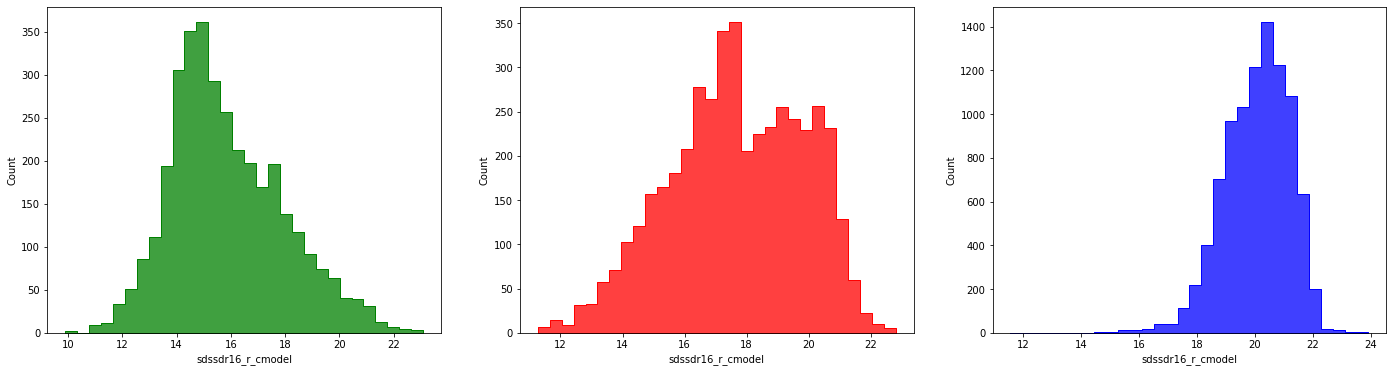

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (24, 6))
sns.histplot(df[df['Label']==0]['sdssdr16_r_cmodel'], ax = ax1, bins = 30, color = 'g', element="step")
sns.histplot(df[df['Label']==2]['sdssdr16_r_cmodel'], ax = ax2, bins = 30, color = 'r', element="step")
sns.histplot(df[df['Label']==1]['sdssdr16_r_cmodel'], ax = ax3, bins = 30, color = 'b', element="step")

In [ ]:
df_s = df[df.Label==0]
df_q = df[df.Label==1]
df_g = df[df.Label==2]

In [ ]:
df_s

,sdssdr16_u_psf,sdssdr16_g_psf,sdssdr16_r_psf,sdssdr16_i_psf,sdssdr16_z_psf,sdssdr16_u_cmodel,sdssdr16_i_cmodel,sdssdr16_u-g_psf,sdssdr16_u-r_psf,sdssdr16_u-i_psf,sdssdr16_u-z_psf,sdssdr16_u_psf-cmodel,sdssdr16_g-i_psf,sdssdr16_g_psf-cmodel,sdssdr16_r-i_psf,sdssdr16_i-z_psf,sdssdr16_i_psf-cmodel,sdssdr16_u_cmodel-decals8tr_Lw1,sdssdr16_u_cmodel-decals8tr_Lw2,sdssdr16_g_cmodel-decals8tr_Lw1,sdssdr16_g_cmodel-decals8tr_Lw2,sdssdr16_r_cmodel-decals8tr_Lw1,sdssdr16_r_cmodel-decals8tr_Lw2,sdssdr16_i_cmodel-decals8tr_Lw1,sdssdr16_i_cmodel-decals8tr_Lw2,sdssdr16_z_cmodel-decals8tr_Lw1,sdssdr16_z_cmodel-decals8tr_Lw2,psdr2_i_kron,psdr2_y_kron,psdr2_g_psf,psdr2_r_psf,psdr2_i_psf,psdr2_z_psf,psdr2_y_psf,psdr2_g-i_psf,psdr2_g-y_psf,psdr2_r-i_psf,psdr2_r-y_psf,psdr2_i-z_psf,psdr2_i-y_psf,psdr2_i_psf-kron,psdr2_z-y_psf,psdr2_y_psf-kron,psdr2_g_kron-decals8tr_Lw1,psdr2_g_kron-decals8tr_Lw2,psdr2_r_kron-decals8tr_Lw1,psdr2_r_kron-decals8tr_Lw2,psdr2_i_kron-decals8tr_Lw1,psdr2_i_kron-decals8tr_Lw2,psdr2_z_kron-decals8tr_Lw1,psdr2_z_kron-decals8tr_Lw2,psdr2_y_kron-decals8tr_Lw1,psdr2_y_kron-decals8tr_Lw2,decals8tr_Lw1-Lw2,decals8tr_Lw1,decals8tr_Lw2,decals8tr_g,decals8tr_r,decals8tr_z,decals8tr_g-r,decals8tr_g-z,decals8tr_r-z,sdssdr16_g_cmodel-decals8tr_g,sdssdr16_r_cmodel-decals8tr_r,sdssdr16_z_cmodel-decals8tr_z,LabelQ,LabelG,LabelS,Label
14095,22.205799,20.147787,19.289909,18.977191,18.667902,20.895187,18.822989,2.058012,2.915890,3.228608,3.537898,1.310613,1.170596,0.061094,0.312718,0.309289,0.154202,1.974550,1.960860,1.166056,1.152367,0.305213,0.291523,-0.097648,-0.111338,-0.425530,-0.439219,18.920448,18.628564,20.006031,19.303136,18.975600,18.842633,18.759075,1.030431,1.246956,0.327537,0.544061,0.132967,0.216524,0.055151,0.083557,0.130512,1.094189,1.080499,0.366355,0.352666,-0.000189,-0.013878,-0.220647,-0.234337,-0.292073,-0.305763,-0.013689,18.920637,18.934326,20.042944,19.211602,18.759660,0.831342,1.283285,0.451942,0.043749,0.014248,-0.264553,0,0,1,0
14096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0
14097,19.140804,17.888408,17.442821,17.247753,17.171994,19.147438,17.253295,1.252396,1.697983,1.893051,1.968810,-0.006634,0.640655,0.004969,0.195068,0.075759,-0.005543,0.812691,0.243831,-0.451308,-1.020168,-0.904510,-1.473370,-1.081452,-1.650312,-1.157631,-1.726491,17.361251,17.204722,17.837975,17.269408,17.273035,17.220647,17.180256,0.564940,0.657720,-0.003628,0.089152,0.052388,0.092780,-0.088216,0.040392,-0.024467,-0.439107,-1.007967,-0.855828,-1.424688,-0.973496,-1.542356,-1.032787,-1.601647,-1.130025,-1.698885,-0.568860,18.334747,18.903607,17.828840,17.366467,17.176663,0.462373,0.652177,0.189804,0.054600,0.063770,0.000453,0,0,1,0
14098,19.882465,18.527261,17.841124,17.628888,17.428524,19.862783,17.609165,1.355204,2.041341,2.253578,2.453942,0.019683,0.898374,0.021378,0.212236,0.200364,0.019722,1.320175,0.703110,-0.036724,-0.653789,-0.703643,-1.320707,-0.933443,-1.550507,-1.096180,-1.713245,17.709008,17.603952,18.415109,17.840860,17.702549,17.514029,17.457911,0.712560,0.957198,0.138311,0.382949,0.188521,0.244638,-0.006458,0.056118,-0.146041,-0.078471,-0.695536,-0.648537,-1.265601,-0.833600,-1.450665,-0.923954,-1.541018,-0.938655,-1.555720,-0.617064,18.542608,19.159672,18.420719,17.778269,17.500613,0.642449,0.920105,0.277656,0.085165,0.060696,-0.054186,0,0,1,0
14099,20.980263,18.559502,17.500689,17.085194,16.828653,20.862707,17.077459,2.420761,3.479574,3.895069,4.151611,0.117557,1.474308,-0.001674,0.415495,0.256542,0.007735,3.275773,2.688127,0.974243,0.386598,-0.101355,-0.689001,-0.509474,-1.097120,-0.745986,-1.333632,17.155033,16.890206,18.422798,17.450494,17.080503,16.921963,16.856364,1.342295,1.566434,0.369991,0.594130,0.158539,0.224139,-0.074530,0.065600,-0.033843,0.907575,0.319929,-0.051811,-0.639456,-0.431901,-1.0

(3462, 69) (9442, 69) (4501, 69)


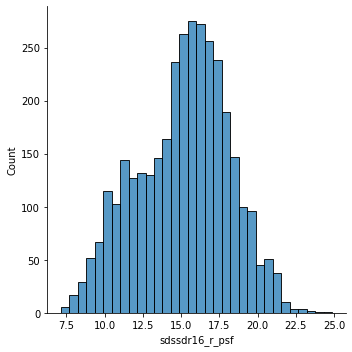

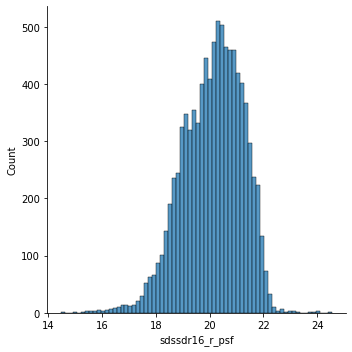

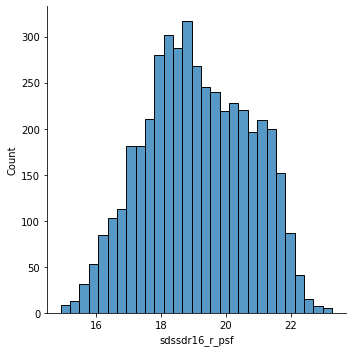

In [ ]:
sns.displot(df_s.sdssdr16_r_psf)
sns.displot(df_q.sdssdr16_r_psf)
sns.displot(df_g.sdssdr16_r_psf)
print(df_s.shape, df_q.shape, df_g.shape)

In [23]:
def data_split(df_all, column='sdssdr16_r_psf', label='Label'):
  df = df_all.sort_values(column)
  def split(df_loc, c=9000):
    data = df_loc.drop(['LabelQ', 'LabelG', 'LabelS', 'Label'], axis = 1).values
    data1 = data[::2]
    data2 = data[1::2]
    print(data, data1, data2)
    np.random.shuffle(data1)
    np.random.shuffle(data2)
    return data1[:c//2], data2[:c//2]

  def train_test(X1, X2, X3, test_size=0.1):
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, 1*np.ones([len(X1), 1]), test_size=test_size, random_state = 43)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, 2*np.ones([len(X2), 1]), test_size=test_size, random_state = 43)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X3, 3*np.ones([len(X3), 1]), test_size=test_size, random_state = 43)

    X_train, X_test = np.concatenate((X1_train, X2_train, X3_train)), np.concatenate((X1_test, X2_test, X3_test))
    y_train, y_test = np.concatenate((y1_train, y2_train, y3_train)), np.concatenate((y1_test, y2_test, y3_test))
        
    train = np.concatenate((X_train, y_train.rashape((len(X_train), 1))))
    test = np.concatenate((X_test, y_test.rashape((len(X_test), 1))))

    return train, test
    
  df_s = df[df[label]==0]
  df_q = df[df[label]==1]
  df_g = df[df[label]==2]

  c = np.min((len(df_s), len(df_q), len(df_g)))


  X1_s , X2_s = split(df_s)
  X1_q , X2_q = split(df_q)
  X1_g , X2_g = split(df_g)


  X1 = np.concatenate((np.concatenate((X1_s, 1*np.ones([len(X1_s), 1])), axis=1),
                       np.concatenate((X1_q, 2*np.ones([len(X1_q), 1])), axis=1),
                       np.concatenate((X1_g, 3*np.ones([len(X1_g), 1])), axis=1)),
                      axis=0)
  X2 = np.concatenate((np.concatenate((X2_s, 1*np.ones([len(X2_s), 1])), axis=1),
                       np.concatenate((X2_q, 2*np.ones([len(X2_q), 1])), axis=1),
                       np.concatenate((X2_g, 3*np.ones([len(X2_g), 1])), axis=1)),
                      axis=0)
  
  np.random.shuffle(X1)
  np.random.shuffle(X2)

  return X1, X2#train1, train2, test1, test2

In [24]:
def scor(y_test, y_pred):
  return accuracy_score(y_test, y_pred)

lgb_reg_params = {
    'min_child_samples':hp.randint('min_child_samples', 50)+1,
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.9),
    'num_leaves' :      hp.randint('num_leaves', 100)+10,
    'min_child_weight': hp.uniform('min_child_weight', 0.001, 0.99),
    'n_estimators':     1000
}
lgb_fit_params = {
    'early_stopping_rounds': 20,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['score'] = lambda y, pred: -accuracy_score(y, pred)


rf_reg_params = {
    'min_samples_leaf': hp.randint('min_samples_leaf', 20)+1,
    'min_samples_split':hp.uniform('min_samples_split', 0.001, 0.1),
    #'max_features':     hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
    #'learning_rate':    hp.uniform('learning_rate', 0.001, 0.1),
    'n_estimators':     hp.randint('n_estimators', 800)+100
}
rf_fit_params = {
}
rf_para = dict()
rf_para['reg_params'] = rf_reg_params
rf_para['fit_params'] = rf_fit_params
rf_para['score'] = lambda y, pred: -accuracy_score(y, pred)

tabnet_reg_params = {
    'n_d' :              64,
    'n_a' :              64,
    'n_steps' :          hp.randint('n_steps', 10-3)+3,
    'gamma' :            hp.uniform('gamma', 1.0, 3.0),
    'lambda_sparse' :    hp.uniform('lambda_sparse', 0.0, 0.01),
    'momentum' :         0.3, 
    'clip_value' :       2.,
    'optimizer_params' : dict(lr=2e-2),
    'scheduler_params' : {"step_size":50, "gamma":0.9},
    'scheduler_fn' :     torch.optim.lr_scheduler.StepLR,
    'mask_type' :       'entmax'
}

tabnet_fit_params = {
    'max_epochs' : 100, 
    'patience' : 15,
    'batch_size' : 512,
    'virtual_batch_size' : 128,
    'num_workers' : 0,
    'weights' : 1,
    'drop_last' : False,
    #'from_unsupervised' : unsupervised_model
}
tabnet_para = dict()
tabnet_para['reg_params'] = tabnet_reg_params
tabnet_para['fit_params'] = tabnet_fit_params
tabnet_para['score'] = lambda y, pred: -accuracy_score(y, pred)

In [25]:
class HPOpt(object):

    def __init__(self, X, y, cv=True):
        self.X = X
        self.y = y
        self.cv = cv

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            print({'status': STATUS_FAIL,
                    'exception': str(e)})
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def rf_reg(self, para):
        reg = RandomForestClassifier(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMClassifier(**para['reg_params'])
        if self.cv:
          return self.train_cv(reg, para)
        return self.train_reg(reg, para)

    def tabnet_reg(self, para):
        reg = TabNetClassifier(**para['reg_params'])
        return self.train_cv(reg, para)


    def train_reg(self, reg, para):
        if len(para['fit_params'])>0:
            reg.fit(self.X, self.y,
                  eval_set=[(self.X, self.y), (self.X, self.t)],
                  **para['fit_params'])
        else:
            reg.fit(self.X, self.y)
        pred = reg.predict(self.X)
        loss = para['score'](self.y, pred)
        return {'loss': loss, 'status': STATUS_OK}

    def train_cv(self, reg, para):
        kf = KFold(n_splits=2, shuffle=False)
        loss = 0 
        for train, test in kf.split(self.X):
            if len(para['fit_params'])>0:
                reg.fit(self.X[train], self.y[train],
                      eval_set=[(self.X[train], self.y[train]), (self.X[test], self.y[test])],
                      **para['fit_params'])
            else:
                reg.fit(self.X[train], self.y[train])
            pred = reg.predict(self.X[test])
            score = para['score'](self.y[test], pred)
            loss += score

        loss=loss/2
        return {'loss': loss, 'status': STATUS_OK}


In [26]:
acc = pd.DataFrame(index=['acc'])

In [ ]:
acc

,sdss,decals,ps,sdss+decals,sdss+ps,ps+decals,all
acc,0.964092,0.958982,0.958806,0.972359,0.96782,0.968395,0.973226


# Обучаем только на SDSS

In [ ]:
overview = 'sdss'

In [148]:
len(sdss)

21

In [ ]:
data1, data2 = data_split(df[sdss].dropna())

In [ ]:
X1, y1 = data1[:,:-1], data1[:,-1].astype('int')
X2, y2 = data2[:,:-1], data2[:,-1].astype('int')

In [ ]:
X1.shape

(8480, 17)

##Обучаем на первой выборке, проверяем на второй

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X1)
X_test_norm = robust.transform(X2)
y_train = y1
y_test = y2

In [ ]:
#obj = HPOpt(X_train_norm, y_train)

In [ ]:
#lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [ ]:
#lgb_opt

In [ ]:
gb = lgb.LGBMClassifier(
    **{'colsample_bytree': 0.3752270436877269,
  'min_child_samples': 40+1,
  'min_child_weight': 0.7184095532059656,
  'num_leaves': 50+10,
  'n_estimators': 1000}
)


t = time()
gb.fit(X_train_norm[:-500], y_train[:-500], eval_set=[(X_train_norm[:-500], y_train[:-500]), (X_train_norm[:-500], y_train[:-500])],  **lgb_fit_params)
print(time()-t)

5.4844889640808105


In [ ]:
pred = gb.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm.astype('float')))
print('Training Score: ', gb_train_acc)
gb_test_acc = accuracy_score(y_test, pred)
acc[overview] = gb_test_acc
print('Training Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.98      0.96      0.97      1730
           2       0.96      0.97      0.97      4500
           3       0.95      0.94      0.95      2250

    accuracy                           0.96      8480
   macro avg       0.96      0.96      0.96      8480
weighted avg       0.96      0.96      0.96      8480

Confusion Matrix: 
 [[1669   45   16]
 [  33 4373   94]
 [   3  125 2122]]
Training Score:  0.9964622641509434
Training Score:  0.9627358490566038


##Обучаем на второй выборке, проверяем на первой

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X2)
X_test_norm = robust.transform(X1)
y_train = y2
y_test = y1

In [ ]:
#obj = HPOpt(X_train_norm, y_train)

In [ ]:
#lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [ ]:
#lgb_opt

In [ ]:
gb = lgb.LGBMClassifier(
    **{'colsample_bytree': 0.7394978740595625,
      'min_child_samples': 16+1,
      'min_child_weight': 0.1265642873892295,
      'num_leaves': 94+10,
      'n_estimators': 1000}
)


t = time()
gb.fit(X_train_norm[:-500], y_train[:-500], eval_set=[(X_train_norm[:-500], y_train[:-500]), (X_train_norm[:-500], y_train[:-500])],  **lgb_fit_params)
print(time()-t)

7.820367097854614


In [ ]:
pred = gb.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm.astype('float')))
print('Training Score: ', gb_train_acc)
gb_test_acc = accuracy_score(y_test, pred)
acc[overview] = (acc[overview] + gb_test_acc)/2
print('Training Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.99      0.96      0.98      1730
           2       0.97      0.97      0.97      4500
           3       0.94      0.95      0.95      2250

    accuracy                           0.97      8480
   macro avg       0.97      0.96      0.96      8480
weighted avg       0.97      0.97      0.97      8480

Confusion Matrix: 
 [[1668   47   15]
 [  16 4372  112]
 [   7   96 2147]]
Training Score:  0.9974056603773584
Training Score:  0.9654481132075472


# Обучаем только на decals

In [ ]:
overview = 'decals'

In [149]:
len(decals)

13

In [ ]:
data1, data2 = data_split(df[decals].dropna(), 'decals8tr_r')

[[  0.26217823   9.41464717   9.15246895 ...  -4.84004766 -13.43904955
   -8.5990019 ]
 [  0.17745963   9.34961965   9.17216002 ...   1.60803036  -6.41288316
   -8.02091352]
 [  0.153528     9.12074033   8.96721234 ...   1.8224283   -4.22339327
   -6.04582157]
 ...
 [ -0.60255292  10.47927689  11.0818298  ... -11.54840686   4.08179483
   15.63020168]
 [ -0.65411008  11.63292086  12.28703094 ...  -0.64045917  14.61866631
   15.25912548]
 [ -0.6000965   10.58879719  11.18889369 ... -22.0848624   -2.86427814
   19.22058426]] [[  0.26217823   9.41464717   9.15246895 ...  -4.84004766 -13.43904955
   -8.5990019 ]
 [  0.153528     9.12074033   8.96721234 ...   1.8224283   -4.22339327
   -6.04582157]
 [ -0.49179392  10.05505866  10.54685258 ...  22.54012283  15.21954755
   -7.32057528]
 ...
 [ -0.54181862  10.4282365   10.97005512 ...   0.37824479  15.004679
   14.62643421]
 [ -0.60255292  10.47927689  11.0818298  ... -11.54840686   4.08179483
   15.63020168]
 [ -0.6000965   10.58879719  11.18

In [ ]:
X1, y1 = data1[:,:-1], data1[:,-1].astype('int')
X2, y2 = data2[:,:-1], data2[:,-1].astype('int')

In [ ]:
X1.shape

(8448, 9)

##Обучаем на первой выборке, проверяем на второй

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X1)
X_test_norm = robust.transform(X2)
y_train = y1
y_test = y2

In [ ]:
#obj = HPOpt(X_train_norm, y_train)

In [ ]:
#lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [ ]:
#lgb_opt

In [ ]:
gb = lgb.LGBMClassifier(
    **{'colsample_bytree': 0.8104497809038045,
  'min_child_samples': 5+1,
  'min_child_weight': 0.9758726061228604,
  'num_leaves': 65+10,
      'n_estimators': 1000}
)


t = time()
gb.fit(X_train_norm[:-500], y_train[:-500], eval_set=[(X_train_norm[:-500], y_train[:-500]), (X_train_norm[:-500], y_train[:-500])],  **lgb_fit_params)
print(time()-t)

6.200746059417725


In [ ]:
pred = gb.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm.astype('float')))
print('Training Score: ', gb_train_acc)
gb_test_acc = accuracy_score(y_test, pred)
acc[overview] = gb_test_acc
print('Training Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.97      0.96      0.97      1706
           2       0.97      0.97      0.97      4500
           3       0.93      0.94      0.94      2241

    accuracy                           0.96      8447
   macro avg       0.96      0.96      0.96      8447
weighted avg       0.96      0.96      0.96      8447

Confusion Matrix: 
 [[1640   30   36]
 [  14 4369  117]
 [  29  103 2109]]
Training Score:  0.9951467803030303
Training Score:  0.9610512608026518


##Обучаем на второй выборке, проверяем на первой

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X2)
X_test_norm = robust.transform(X1)
y_train = y2
y_test = y1

In [ ]:
#obj = HPOpt(X_train_norm, y_train)

In [ ]:
#lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [ ]:
#lgb_opt

In [ ]:
gb = lgb.LGBMClassifier(
    **{'colsample_bytree': 0.4068541706198642,
  'min_child_samples': 11+1,
  'min_child_weight': 0.06272672350564332,
  'num_leaves': 1+10,
      'n_estimators': 1000}
)


t = time()
gb.fit(X_train_norm[:-500], y_train[:-500], eval_set=[(X_train_norm[:-500], y_train[:-500]), (X_train_norm[:-500], y_train[:-500])],  **lgb_fit_params)
print(time()-t)

3.792611837387085


In [ ]:
pred = gb.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm.astype('float')))
print('Training Score: ', gb_train_acc)
gb_test_acc = accuracy_score(y_test, pred)
acc[overview] = (acc[overview] + gb_test_acc)/2
print('Training Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.97      0.95      0.96      1707
           2       0.97      0.97      0.97      4500
           3       0.93      0.94      0.93      2241

    accuracy                           0.96      8448
   macro avg       0.95      0.95      0.95      8448
weighted avg       0.96      0.96      0.96      8448

Confusion Matrix: 
 [[1624   34   49]
 [  20 4362  118]
 [  32  111 2098]]
Training Score:  0.9955013614300935
Training Score:  0.9569128787878788


# Обучаем только на PanStars

In [ ]:
overview = 'ps'

In [150]:
len(ps)

20

In [ ]:
data1, data2 = data_split(df[ps].dropna(), 'psdr2_r_psf')

[[12.17900645 11.16607677 12.347154   ...  0.         -0.17530019
   0.44061258]
 [12.92595218 10.481565   12.77834023 ... -1.78081752  1.80119602
  -0.79847213]
 [11.03919022 10.88226782 11.23045471 ...  0.         -0.59540646
   0.49064453]
 ...
 [13.56105427 11.63453763 11.92288652 ... 13.21145735  0.68786227
   0.15804971]
 [14.84441555 11.92918359 12.86315534 ...  0.          1.40868434
   0.0656633 ]
 [12.67790691 12.50346556 13.57709838 ...  0.48292688  0.31582203
   0.08938451]] [[12.17900645 11.16607677 12.347154   ...  0.         -0.17530019
   0.44061258]
 [11.03919022 10.88226782 11.23045471 ...  0.         -0.59540646
   0.49064453]
 [11.23227248 10.79290003 12.16429912 ...  0.          1.24353279
   0.21495824]
 ...
 [12.85087038 12.04507608 26.85110731 ... 13.79971166  0.0489412
   0.20595001]
 [13.06877627 11.89068047 13.03883522 ... -0.89973457 -1.18879058
   0.84074796]
 [14.84441555 11.92918359 12.86315534 ...  0.          1.40868434
   0.0656633 ]] [[12.92595218 10.

In [ ]:
X1, y1 = data1[:,:-1], data1[:,-1].astype('int')
X2, y2 = data2[:,:-1], data2[:,-1].astype('int')

In [ ]:
X1.shape

(7101, 16)

##Обучаем на первой выборке, проверяем на второй

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X1)
X_test_norm = robust.transform(X2)
y_train = y1
y_test = y2

In [ ]:
#obj = HPOpt(X_train_norm, y_train)

In [ ]:
#lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [ ]:
#lgb_opt

In [ ]:
gb = lgb.LGBMClassifier(
    **{'colsample_bytree': 0.6642887258022818,
  'min_child_samples': 4+1,
  'min_child_weight': 0.775262820204908,
  'num_leaves': 6+10,
      'n_estimators': 1000}
)


t = time()
gb.fit(X_train_norm[:-500], y_train[:-500], eval_set=[(X_train_norm[:-500], y_train[:-500]), (X_train_norm[:-500], y_train[:-500])],  **lgb_fit_params)
print(time()-t)

4.849103927612305


In [ ]:
pred = gb.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm.astype('float')))
print('Training Score: ', gb_train_acc)
gb_test_acc = accuracy_score(y_test, pred)
acc[overview] = gb_test_acc
print('Training Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.97      0.94      0.96      1167
           2       0.96      0.97      0.96      4027
           3       0.94      0.94      0.94      1906

    accuracy                           0.96      7100
   macro avg       0.96      0.95      0.95      7100
weighted avg       0.96      0.96      0.96      7100

Confusion Matrix: 
 [[1101   55   11]
 [  27 3896  104]
 [   5  101 1800]]
Training Score:  0.9957752429235319
Training Score:  0.9573239436619718


##Обучаем на второй выборке, проверяем на первой

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X2)
X_test_norm = robust.transform(X1)
y_train = y2
y_test = y1

In [ ]:
#obj = HPOpt(X_train_norm, y_train)

In [ ]:
#lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [ ]:
#lgb_opt

In [ ]:
gb = lgb.LGBMClassifier(
    **{'colsample_bytree': 0.44232732453787127,
  'min_child_samples': 39+1,
  'min_child_weight': 0.15636662933973536,
  'num_leaves': 25+10,
      'n_estimators': 1000}
)


t = time()
gb.fit(X_train_norm[:-500], y_train[:-500], eval_set=[(X_train_norm[:-500], y_train[:-500]), (X_train_norm[:-500], y_train[:-500])],  **lgb_fit_params)
print(time()-t)

5.247951984405518


In [ ]:
pred = gb.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm.astype('float')))
print('Training Score: ', gb_train_acc)
gb_test_acc = accuracy_score(y_test, pred)
acc[overview] = (acc[overview] + gb_test_acc)/2
print('Training Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.97      0.94      0.96      1167
           2       0.97      0.97      0.97      4028
           3       0.94      0.95      0.95      1906

    accuracy                           0.96      7101
   macro avg       0.96      0.95      0.96      7101
weighted avg       0.96      0.96      0.96      7101

Confusion Matrix: 
 [[1100   52   15]
 [  31 3902   95]
 [   5   84 1817]]
Training Score:  0.995774647887324
Training Score:  0.9602872834811998


# Обучаем на SDSS and decals

In [ ]:
overview = 'sdss+decals'

In [152]:
sdss_decals = [i for i in features if ('sdss' in i or 'decals' in i) and 'psdr' not in i] + ['LabelQ', 'LabelG', 'LabelS', 'Label']

In [153]:
len(sdss_decals)

43

In [ ]:
data1, data2 = data_split(df[sdss_decals].dropna())

[[ 8.32313612  7.06674872  7.14253691 ...  3.29560597  2.38805577
  -0.15290435]
 [14.34546057 13.89415478  7.29767599 ...  0.62771844  1.51317155
  -2.76776875]
 [ 8.8665732  11.04006502  7.34243742 ...  3.23131392  1.0449481
  -0.78204208]
 ...
 [23.11332269 24.02218114 23.64032341 ...  0.64568178  1.42733941
   0.09861513]
 [24.36290307 15.82685278 23.92909239 ... -1.90784587 -1.30835829
  -1.39195694]
 [24.18340755 25.12869598 24.85982292 ...  2.83996985  0.82611757
  -0.23275616]] [[ 8.32313612  7.06674872  7.14253691 ...  3.29560597  2.38805577
  -0.15290435]
 [ 8.8665732  11.04006502  7.34243742 ...  3.23131392  1.0449481
  -0.78204208]
 [ 8.85890032  8.16954477  7.63161607 ...  1.45292819  0.50861688
  -0.92139865]
 ...
 [23.10549057 23.87371022 22.91696185 ...  3.21728682 -0.49271541
   0.18148377]
 [23.11332269 24.02218114 23.64032341 ...  0.64568178  1.42733941
   0.09861513]
 [24.18340755 25.12869598 24.85982292 ...  2.83996985  0.82611757
  -0.23275616]] [[14.34546057 13.8

In [ ]:
X1, y1 = data1[:,:-1], data1[:,-1].astype('int')
X2, y2 = data2[:,:-1], data2[:,-1].astype('int')

In [ ]:
X1.shape

(8448, 39)

##Обучаем на первой выборке, проверяем на второй

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X1)
X_test_norm = robust.transform(X2)
y_train = y1
y_test = y2

In [ ]:
#obj = HPOpt(X_train_norm, y_train)

In [ ]:
#lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [ ]:
#lgb_opt

In [ ]:
gb = lgb.LGBMClassifier(
    **{'colsample_bytree': 0.5048269884336619,
  'min_child_samples': 49+1,
  'min_child_weight': 0.4809285563025559,
  'num_leaves': 26+10,
      'n_estimators': 1000}
)


t = time()
gb.fit(X_train_norm[:-500], y_train[:-500], eval_set=[(X_train_norm[:-500], y_train[:-500]), (X_train_norm[:-500], y_train[:-500])],  **lgb_fit_params)
print(time()-t)

7.429488658905029


In [ ]:
pred = gb.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm.astype('float')))
print('Training Score: ', gb_train_acc)
gb_test_acc = accuracy_score(y_test, pred)
acc[overview] = gb_test_acc
print('Training Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.99      0.97      0.98      1706
           2       0.98      0.98      0.98      4500
           3       0.96      0.96      0.96      2241

    accuracy                           0.97      8447
   macro avg       0.97      0.97      0.97      8447
weighted avg       0.97      0.97      0.97      8447

Confusion Matrix: 
 [[1663   27   16]
 [  17 4401   82]
 [   5   84 2152]]
Training Score:  0.9968039772727273
Training Score:  0.9726530129039895


##Обучаем на второй выборке, проверяем на первой

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X2)
X_test_norm = robust.transform(X1)
y_train = y2
y_test = y1

In [ ]:
#obj = HPOpt(X_train_norm, y_train)

In [ ]:
#lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [ ]:
#lgb_opt

In [ ]:
gb = lgb.LGBMClassifier(
    **{'colsample_bytree': 0.8753852156471218,
  'min_child_samples': 32+1,
  'min_child_weight': 0.9825613994422406,
  'num_leaves': 65+10,
      'n_estimators': 1000}
)


t = time()
gb.fit(X_train_norm[:-500], y_train[:-500], eval_set=[(X_train_norm[:-500], y_train[:-500]), (X_train_norm[:-500], y_train[:-500])],  **lgb_fit_params)
print(time()-t)

8.455375671386719


In [ ]:
pred = gb.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm.astype('float')))
print('Training Score: ', gb_train_acc)
gb_test_acc = accuracy_score(y_test, pred)
acc[overview] = (acc[overview] + gb_test_acc)/2
print('Training Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.99      0.98      0.98      1707
           2       0.98      0.97      0.98      4500
           3       0.95      0.96      0.95      2241

    accuracy                           0.97      8448
   macro avg       0.97      0.97      0.97      8448
weighted avg       0.97      0.97      0.97      8448

Confusion Matrix: 
 [[1679   14   14]
 [  19 4386   95]
 [   6   88 2147]]
Training Score:  0.9976322954895229
Training Score:  0.9720643939393939


# Обучаем на SDSS and PanStars

In [ ]:
overview = 'sdss+ps'

In [154]:
sdss_ps = [i for i in features if ('sdss' in i or 'psdr' in i) and 'decals' not in i] + ['LabelQ', 'LabelG', 'LabelS', 'Label']

In [155]:
len(sdss_ps)

37

In [ ]:
data1, data2 = data_split(df[sdss_ps].dropna())

[[ 1.43454606e+01  1.38941548e+01  7.29767599e+00 ...  8.10714351e-01
   2.75247402e-01 -1.98030407e-02]
 [ 1.13680256e+01  1.01497681e+01  9.68987750e+00 ...  1.27953714e+01
   1.57979427e+00 -5.98191351e-01]
 [ 1.11709129e+01  1.00061718e+01  9.75755261e+00 ... -2.71915287e-01
   1.06058999e+01  0.00000000e+00]
 ...
 [ 2.35840971e+01  2.49898294e+01  2.35325438e+01 ... -6.08689677e-02
   4.50813531e-01 -1.51341389e-02]
 [ 2.31133227e+01  2.40221811e+01  2.36403234e+01 ... -6.76038425e-02
   5.74629863e-01 -7.89346538e-02]
 [ 2.41834075e+01  2.51286960e+01  2.48598229e+01 ...  5.61210198e-01
   2.12632938e-01  4.63558781e-01]] [[ 1.43454606e+01  1.38941548e+01  7.29767599e+00 ...  8.10714351e-01
   2.75247402e-01 -1.98030407e-02]
 [ 1.11709129e+01  1.00061718e+01  9.75755261e+00 ... -2.71915287e-01
   1.06058999e+01  0.00000000e+00]
 [ 1.22559279e+01  1.06389340e+01  1.01326665e+01 ...  0.00000000e+00
   4.91487918e+00  0.00000000e+00]
 ...
 [ 2.32742668e+01  2.37942077e+01  2.2655316

In [ ]:
X1, y1 = data1[:,:-1], data1[:,-1].astype('int')
X2, y2 = data2[:,:-1], data2[:,-1].astype('int')

In [ ]:
X1.shape

(7070, 33)

##Обучаем на первой выборке, проверяем на второй

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X1)
X_test_norm = robust.transform(X2)
y_train = y1
y_test = y2

In [ ]:
#obj = HPOpt(X_train_norm, y_train)

In [ ]:
#lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [ ]:
#lgb_opt

In [ ]:
gb = lgb.LGBMClassifier(
    **{'colsample_bytree': 0.6756414264650209,
  'min_child_samples': 16+1,
  'min_child_weight': 0.011169721239062961,
  'num_leaves': 38+10,
      'n_estimators': 1000}
)


t = time()
gb.fit(X_train_norm[:-500], y_train[:-500], eval_set=[(X_train_norm[:-500], y_train[:-500]), (X_train_norm[:-500], y_train[:-500])],  **lgb_fit_params)
print(time()-t)

8.22081208229065


In [ ]:
pred = gb.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm.astype('float')))
print('Training Score: ', gb_train_acc)
gb_test_acc = accuracy_score(y_test, pred)
acc[overview] = gb_test_acc
print('Training Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.98      0.96      0.97      1167
           2       0.98      0.97      0.98      3996
           3       0.95      0.96      0.96      1906

    accuracy                           0.97      7069
   macro avg       0.97      0.97      0.97      7069
weighted avg       0.97      0.97      0.97      7069

Confusion Matrix: 
 [[1125   33    9]
 [  23 3893   80]
 [   4   63 1839]]
Training Score:  0.9963224893917964
Training Score:  0.97000990239072


##Обучаем на второй выборке, проверяем на первой

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X2)
X_test_norm = robust.transform(X1)
y_train = y2
y_test = y1

In [ ]:
#obj = HPOpt(X_train_norm, y_train)

In [ ]:
#lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [ ]:
#lgb_opt

In [ ]:
gb = lgb.LGBMClassifier(
    **{'colsample_bytree': 0.7097663865005799,
  'min_child_samples': 40+1,
  'min_child_weight': 0.09319093708977999,
  'num_leaves': 65+10,
      'n_estimators': 1000}
)


t = time()
gb.fit(X_train_norm[:-500], y_train[:-500], eval_set=[(X_train_norm[:-500], y_train[:-500]), (X_train_norm[:-500], y_train[:-500])],  **lgb_fit_params)
print(time()-t)

8.605796813964844


In [ ]:
pred = gb.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm.astype('float')))
print('Training Score: ', gb_train_acc)
gb_test_acc = accuracy_score(y_test, pred)
acc[overview] = (acc[overview] + gb_test_acc)/2
print('Training Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.98      0.95      0.97      1167
           2       0.97      0.97      0.97      3997
           3       0.94      0.96      0.95      1906

    accuracy                           0.97      7070
   macro avg       0.97      0.96      0.96      7070
weighted avg       0.97      0.97      0.97      7070

Confusion Matrix: 
 [[1109   41   17]
 [  17 3888   92]
 [   1   75 1830]]
Training Score:  0.9958975809874098
Training Score:  0.9656294200848656


# Обучаем на decals and PanStars

In [ ]:
overview = 'ps+decals'

In [156]:
ps_decals = [i for i in features if ('decals' in i or 'psdr' in i) and 'sdss' not in i] + ['LabelQ', 'LabelG', 'LabelS', 'Label']

In [157]:
len(ps_decals)

39

In [ ]:
data1, data2 = data_split(df[ps_decals].dropna(), 'psdr2_r_psf')

In [ ]:
X1, y1 = data1[:,:-1], data1[:,-1].astype('int')
X2, y2 = data2[:,:-1], data2[:,-1].astype('int')

In [ ]:
X1.shape

(7072, 35)

##Обучаем на первой выборке, проверяем на второй

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X1)
X_test_norm = robust.transform(X2)
y_train = y1
y_test = y2

In [ ]:
#obj = HPOpt(X_train_norm, y_train)

In [ ]:
#lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [ ]:
#lgb_opt

In [ ]:
gb = lgb.LGBMClassifier(
    **{'colsample_bytree': 0.4287682144495232,
  'min_child_samples': 41+1,
  'min_child_weight': 0.8439517049649784,
  'num_leaves': 37+10,
      'n_estimators': 1000}
)


t = time()
gb.fit(X_train_norm[:-500], y_train[:-500], eval_set=[(X_train_norm[:-500], y_train[:-500]), (X_train_norm[:-500], y_train[:-500])],  **lgb_fit_params)
print(time()-t)

5.7620885372161865


In [ ]:
pred = gb.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm.astype('float')))
print('Training Score: ', gb_train_acc)
gb_test_acc = accuracy_score(y_test, pred)
acc[overview] = gb_test_acc
print('Training Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.98      0.97      0.98      1152
           2       0.98      0.97      0.98      4020
           3       0.95      0.97      0.96      1899

    accuracy                           0.97      7071
   macro avg       0.97      0.97      0.97      7071
weighted avg       0.97      0.97      0.97      7071

Confusion Matrix: 
 [[1123   20    9]
 [  21 3917   82]
 [   7   54 1838]]
Training Score:  0.9958993212669683
Training Score:  0.9727054164898883


##Обучаем на второй выборке, проверяем на первой

In [ ]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X2)
X_test_norm = robust.transform(X1)
y_train = y2
y_test = y1

In [ ]:
#obj = HPOpt(X_train_norm, y_train)

In [ ]:
#lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [ ]:
#lgb_opt

In [ ]:
gb = lgb.LGBMClassifier(
    **{'colsample_bytree': 0.8979758467441785,
  'min_child_samples': 20,
  'min_child_weight': 0.6165560587018821,
  'num_leaves': 52+10,
      'n_estimators': 1000}
)


t = time()
gb.fit(X_train_norm[:-500], y_train[:-500], eval_set=[(X_train_norm[:-500], y_train[:-500]), (X_train_norm[:-500], y_train[:-500])],  **lgb_fit_params)
print(time()-t)

6.9347662925720215


In [ ]:
pred = gb.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm.astype('float')))
print('Training Score: ', gb_train_acc)
gb_test_acc = accuracy_score(y_test, pred)
acc[overview] = (acc[overview] + gb_test_acc)/2
print('Training Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.98      0.96      0.97      1152
           2       0.97      0.97      0.97      4020
           3       0.94      0.95      0.95      1900

    accuracy                           0.96      7072
   macro avg       0.96      0.96      0.96      7072
weighted avg       0.96      0.96      0.96      7072

Confusion Matrix: 
 [[1111   28   13]
 [  19 3906   95]
 [   7   92 1801]]
Training Score:  0.9967472776127846
Training Score:  0.9640837104072398


# Обучаем на всей выборке

In [27]:
overview = 'all'

In [158]:
len(features)

69

In [28]:
data1, data2 = data_split(df[features].dropna())

[[14.34546057 13.89415478  7.29767599 ...  0.62771844  1.51317155
  -2.76776875]
 [11.36802556 10.14976812  9.6898775  ...  1.54674132  1.87814739
  -0.2598255 ]
 [11.17091291 10.00617184  9.75755261 ...  3.0413092   0.57088776
  -1.22056085]
 ...
 [23.58409707 24.98982939 23.53254382 ...  1.30199583  3.21635345
   0.08307366]
 [23.11332269 24.02218114 23.64032341 ...  0.64568178  1.42733941
   0.09861513]
 [24.18340755 25.12869598 24.85982292 ...  2.83996985  0.82611757
  -0.23275616]] [[14.34546057 13.89415478  7.29767599 ...  0.62771844  1.51317155
  -2.76776875]
 [11.17091291 10.00617184  9.75755261 ...  3.0413092   0.57088776
  -1.22056085]
 [12.25592793 10.63893401 10.13266654 ...  1.23259915  1.62019655
   1.1198265 ]
 ...
 [23.27426677 23.79420769 22.65531679 ... -1.88550701 -0.28586571
  -0.10112914]
 [23.10549057 23.87371022 22.91696185 ...  3.21728682 -0.49271541
   0.18148377]
 [23.11332269 24.02218114 23.64032341 ...  0.64568178  1.42733941
   0.09861513]] [[ 11.36802556  

In [29]:
X1, y1 = data1[:,:-1], data1[:,-1].astype('int')
X2, y2 = data2[:,:-1], data2[:,-1].astype('int')

In [30]:
X1.shape

(7041, 65)

##Обучаем на первой выборке, проверяем на второй

In [31]:
robust1 = RobustScaler()

X_train_norm = robust1.fit_transform(X1)
X_test_norm = robust1.transform(X2)
y_train = y1
y_test = y2

In [264]:
#obj = HPOpt(X_train_norm, y_train)

In [265]:
#lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [266]:
#lgb_opt

In [32]:
gb1 = lgb.LGBMClassifier(
    **{'colsample_bytree': 0.8211965075024374,
  'min_child_samples': 33+1,
  'min_child_weight': 0.9636584831554481,
  'num_leaves': 67+10,
      'n_estimators': 1000}
)


t = time()
gb1.fit(X_train_norm[:-500], y_train[:-500], eval_set=[(X_train_norm[:-500], y_train[:-500]), (X_train_norm[:-500], y_train[:-500])],  **lgb_fit_params)
print(time()-t)

11.17336893081665


In [33]:
pred = gb1.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb1.predict(X_train_norm.astype('float')))
print('Training Score: ', gb_train_acc)
gb_test_acc = accuracy_score(y_test, pred)
#acc[overview] = gb_test_acc
print('Training Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.99      0.97      0.98      1152
           2       0.98      0.98      0.98      3989
           3       0.96      0.97      0.96      1899

    accuracy                           0.97      7040
   macro avg       0.97      0.97      0.97      7040
weighted avg       0.97      0.97      0.97      7040

Confusion Matrix: 
 [[1121   20   11]
 [  13 3901   75]
 [   3   57 1839]]
Training Score:  0.9960232921460019
Training Score:  0.9745738636363637


##Обучаем на второй выборке, проверяем на первой

In [34]:
robust2 = RobustScaler()

X_train_norm = robust2.fit_transform(X2)
X_test_norm = robust2.transform(X1)
y_train = y2
y_test = y1

In [35]:
#obj = HPOpt(X_train_norm, y_train)

In [36]:
#lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [37]:
#lgb_opt

In [38]:
gb2 = lgb.LGBMClassifier(
    **{'colsample_bytree': 0.7122774534428687,
  'min_child_samples': 12,
  'min_child_weight': 0.5902465770913051,
  'num_leaves': 0+10,
      'n_estimators': 1000}
)


t = time()
gb2.fit(X_train_norm[:-500], y_train[:-500], eval_set=[(X_train_norm[:-500], y_train[:-500]), (X_train_norm[:-500], y_train[:-500])],  **lgb_fit_params)
print(time()-t)

7.7135820388793945


In [39]:
pred = gb2.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb2.predict(X_train_norm.astype('float')))
print('Training Score: ', gb_train_acc)
gb_test_acc = accuracy_score(y_test, pred)
#acc[overview] = (acc[overview] + gb_test_acc)/2
print('Training Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.98      0.98      0.98      1152
           2       0.98      0.98      0.98      3989
           3       0.95      0.96      0.95      1900

    accuracy                           0.97      7041
   macro avg       0.97      0.97      0.97      7041
weighted avg       0.97      0.97      0.97      7041

Confusion Matrix: 
 [[1124   19    9]
 [  18 3892   79]
 [   4   80 1816]]
Training Score:  0.9961647727272728
Training Score:  0.9703167163755149


# Построение графиков

In [105]:
a = np.array([np.arange(10),np.arange(10)]) 
print(a)
a[[True]*2]

[[0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]]


array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [143]:
def acc_for_features(X1, y1, X2, y2, model1, model2, n_split, n_features, robust1, robust2):
  from sklearn.metrics import f1_score

  def get_pred(X, y, model, r1, r2, robust):
    ind = (X[:, n_features]>r1) & (X[:, n_features]< r2)
    print(np.sum(ind), np.sum([X[:, n_features]>r1]), np.sum([X[:, n_features]< r2]))
    X = X[ind]
    y = y[ind]
    
    print(r1, r2)
    print((np.sum(y==1), np.sum(y==2), np.sum(y==3)))
    size = np.min((np.sum(y==1), np.sum(y==3), np.sum(y==2))) #для уравновешивания классов
    print(size)
    if size < 50:
      return [0], [0]
    test = np.concatenate((X[y==1][:size], X[y==2][:size], X[y==3][:size]))
    yt = np.concatenate((y[y==1][:size], y[y==2][:size], y[y==3][:size]))

    return yt, model.predict(robust.transform(test))#_proba

  q = np.linspace(0, 1, num=n_split+1)
  feature_q = np.quantile(np.concatenate((X1, X2))[:, n_features], q)

  Acc = []
  feature = []
  r0 = feature_q[0]

  for i in range(n_split):

    r1 = feature_q[i+1]

    yt1, yp1 = get_pred(X1, y1, model1, r0, r1, robust1)
    yt2, yp2 = get_pred(X2, y2, model2, r0, r1, robust2)
    if (len(yt1) == 1 or len(yt2) == 1):
      continue
     

    y_true = np.concatenate((yt1, yt2))
    y_pred = np.concatenate((yp1, yp2))

    Acc.append(f1_score(y_true, y_pred, average=None))
    feature.append(np.mean((r0, r1)))
    r0 = r1
    print('not cont')

    #ind1 = tuple([X_true[:,n_features]>feature_q[i]] and [X_true[:,n_features]<feature_q[i+1]])
    #ind2 = tuple([X_false[:,n_features]>feature_q[i]] and [X_false[:,n_features]<feature_q[i+1]])
    #test = np.concatenate((X_true[ind1], np.random.permutation(X_false[ind2])))
    #print(len(test))
    #yt = np.concatenate((y_true[ind1], y_false[ind2]))
    #yp = model.predict_proba(test)
    
   
  return Acc, feature

In [144]:

def auc(y, pred, pos_label):
  import numpy as np
  from sklearn import metrics
  fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=pos_label)
  return metrics.auc(fpr, tpr)

In [ ]:
acc, r = acc_for_features(X2, y2, X1, y1, gb1, gb2, 5, 2, robust1, robust2)

In [146]:
acc = np.array(acc).T

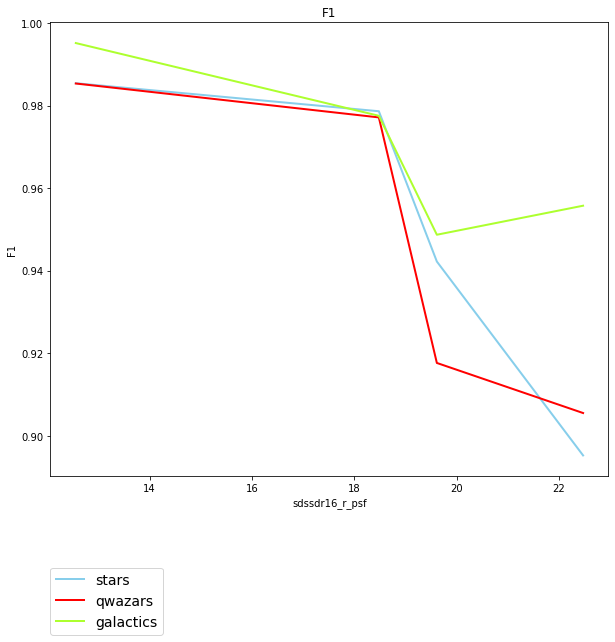

In [147]:
    plt.figure(figsize=(10, 10))
    lab =['stars', 'qwazars', 'galactics']
    lines = []
    labels = []
    clr = ['skyblue', 'red', 'greenyellow', 'orangered', 'chocolate', 'darkorange', 'orange', 'gold', 'yellow', 'lime', 'springgreen', 'aquamarine', 'aqua',  'lightskyblue']
    for j in range(3):
      l, = plt.plot(r, acc[j], color=clr[j], lw=2)
      lines.append(l)
      labels.append(lab[j])


    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)

    plt.xlabel('sdssdr16_r_psf')
    plt.ylabel('F1')
    plt.title('F1')
    plt.legend(lines, labels, loc=(0, -0.35), prop=dict(size=14))
    plt.show()

In [260]:
def prec_rec(ml, X1_test, y1_test, X2_test, y2_test, X3_test, y3_test, true_rt=False, rt = None):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc

    feature = 2
    
    X_test_not_scaling = X1_test[X1_test[:,feature].argsort()]
    X_test = X1_test[X1_test[:,feature].argsort()]#################
    if true_rt:
      X_test = rt.transform(X_test)
    y_test = y1_test[X1_test[:,feature].argsort()]
    
    #shift = 1000
    #n = len(y_test)//shift
    n = 2
    shift = len(y_test)//n

    plt.figure(figsize=(10, 10))
    lines = []
    labels = []
    AUC = []
    r = []
    clr = ['red', 'orangered', 'chocolate', 'darkorange', 'orange', 'gold', 'yellow', 'greenyellow', 'lime', 'springgreen', 'aquamarine', 'aqua', 'skyblue', 'lightskyblue']
   
    #y_pred_all = ml.predict(X_test)
    y_pred_all_proba = ml.predict_proba(X_test)
    j = 0

    for i in range(0, n):
            r1 = X_test_not_scaling[i*shift][feature]
            r2 = X_test_not_scaling[(i+1) * shift - 1][feature]

            X2 = X2_test[(X2_test[:, feature] >= r1) & (X2_test[:, feature] <= r2)]
            y2 = y2_test[(X2_test[:, feature] >= r1) & (X2_test[:, feature] <= r2)]
            ind2 = np.random.choice(len(y2), size=min(shift, len(y2)), replace=False)

            X3 = X3_test[(X3_test[:, feature] >= r1) & (X3_test[:, feature] <= r2)]
            y3 = y3_test[(X3_test[:, feature] >= r1) & (X3_test[:, feature] <= r2)]
            ind3 = np.random.choice(len(y3), size=min(shift, len(y3)), replace=False)

            X = np.concatenate((X2[ind2], X3[ind3]))
            if true_rt:
              X = rt.transform(X)
            y = np.concatenate((y2[ind2], y3[ind3]))

            print(i, shift, len(y2), len(y3))

            yt = np.concatenate((y_test[i*shift : (i+1) * shift], y))
            yt = label_binarize(yt, classes=[1, 2, 3])
            yp = np.concatenate((y_pred_all_proba[i*shift : (i+1) * shift], ml.predict_proba(X)))###################

            f, t, thresholds = roc_curve(yt.ravel(), yp.ravel())
            l, = plt.plot(f, t, color=clr[j], lw=2)
            j+=1
            lines.append(l)
            r1 = X_test_not_scaling[i*shift : (i+1) * shift][:,feature].mean()
            labels.append('r = ' + str(r1))
            r.append(r1)
            AUC.append(auc(f, t))
            
    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC multi-class')
    plt.legend(lines, labels, loc=(0, -0.75), prop=dict(size=14))
    plt.show()

    plt.figure()
    plt.title('AUC')
    plt.plot(r, AUC, 'b')
    plt.plot([0,1],[0,1],'r--')
    plt.ylim([0.75, 1])
    plt.xlim([22,16])
    plt.ylabel('AUC')
    plt.xlabel('R')
    plt.show()

In [ ]:
prec_rec(gb, X2[y2==1], y2[y2==1], X2[y2==2], y2[y2==2], X2[y2==3], y2[y2==3], True, robust)

In [ ]:
 X2

In [58]:
acc = lambda X, y : accuracy_score(y, gb.predict(robust.transform(X).astype('float')))


#Далее

In [ ]:
X1.shape, X2.shape

((8480, 17), (8480, 17))

In [ ]:
X_train.shape

(6336, 65)

In [ ]:
gb = lgb.LGBMClassifier()
t = time()
gb.fit(X_train_norm, y_train, eval_set=[(X_train_norm, y_train), (X_test_norm, y_test)],  **lgb_fit_params)
print(time()-t)

1.1678180694580078


In [ ]:
pred = gb.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm))
print('Training Score: ', gb_train_acc)
gb_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.97      0.96      0.96       116
           2       0.98      0.98      0.98       399
           3       0.98      0.96      0.97       190

    accuracy                           0.97       705
   macro avg       0.97      0.97      0.97       705
weighted avg       0.97      0.97      0.97       705

Confusion Matrix: 
 [[111   4   1]
 [  3 393   3]
 [  1   6 183]]
Training Score:  0.9970012626262627
Testing Score:  0.9744680851063829


In [ ]:
pred = gb.predict(X2_norm)
print('Classification Report: \n', classification_report(y2, pred))
print('Confusion Matrix: \n', confusion_matrix(y2, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm.astype('float')))
print('Training Score: ', gb_train_acc)
gb_test_acc = accuracy_score(y2, pred)
print('Training Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.99      0.99      0.99      1152
           2       1.00      1.00      1.00      3989
           3       0.99      0.99      0.99      1900

    accuracy                           0.99      7041
   macro avg       0.99      0.99      0.99      7041
weighted avg       0.99      0.99      0.99      7041

Confusion Matrix: 
 [[1142    7    3]
 [   5 3974   10]
 [   1   11 1888]]
Training Score:  0.9970012626262627
Training Score:  0.9947450646215026


In [ ]:
X_train.shape, X_test.shape

((6340, 65), (706, 65))

In [ ]:
clf = TabNetClassifier(n_d=32, n_a=32,
                       momentum=0.7,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":20, # how to use learning rate scheduler
                                         "gamma":0.95},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,

                       mask_type='entmax',
                       
                       **{'gamma': 1.7,
                          'lambda_sparse': 0.001,
                          'n_steps': 5}

)

Device used : cuda


In [ ]:
max_epochs = 300

In [ ]:
X_train.shape

(6336, 65)

In [ ]:
X_test.shape

(705, 65)

In [ ]:
t = time()
clf.fit(
    X_train=X_train, y_train=y_train,
    #X_valid=X_valid, y_valid=y_valid,
    eval_set=[(X_train, y_train), (X_train, y_train)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss','accuracy'],
    max_epochs=max_epochs , patience=50,
    batch_size=512, virtual_batch_size=128,
    #from_unsupervised=unsupervised_model
) 
print(time()-t)

epoch 0  | loss: 0.96442 | train_logloss: 5.35252 | train_accuracy: 0.42551 | valid_logloss: 5.35252 | valid_accuracy: 0.42551 |  0:00:00s
epoch 1  | loss: 0.32988 | train_logloss: 2.74    | train_accuracy: 0.64378 | valid_logloss: 2.74    | valid_accuracy: 0.64378 |  0:00:01s
epoch 2  | loss: 0.27342 | train_logloss: 3.26327 | train_accuracy: 0.41525 | valid_logloss: 3.26327 | valid_accuracy: 0.41525 |  0:00:02s
epoch 3  | loss: 0.2023  | train_logloss: 9.63578 | train_accuracy: 0.34501 | valid_logloss: 9.63578 | valid_accuracy: 0.34501 |  0:00:03s
epoch 4  | loss: 0.19852 | train_logloss: 3.86725 | train_accuracy: 0.41177 | valid_logloss: 3.86725 | valid_accuracy: 0.41177 |  0:00:04s
epoch 5  | loss: 0.16243 | train_logloss: 2.8799  | train_accuracy: 0.65025 | valid_logloss: 2.8799  | valid_accuracy: 0.65025 |  0:00:05s
epoch 6  | loss: 0.18096 | train_logloss: 0.91737 | train_accuracy: 0.79419 | valid_logloss: 0.91737 | valid_accuracy: 0.79419 |  0:00:06s
epoch 7  | loss: 0.15446 | 

In [ ]:
X_test = X_test.astype('float')

In [ ]:
pred = clf.predict(X_test)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
clf_train_acc = accuracy_score(y_train, clf.predict(X_train.astype('float')))
print('Training Score: ', clf_train_acc)
clf_test_acc = accuracy_score(y_test, pred)
print('Testing Score: ', clf_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.99      0.96      0.97       116
           2       0.98      0.98      0.98       399
           3       0.95      0.96      0.95       190

    accuracy                           0.97       705
   macro avg       0.97      0.96      0.97       705
weighted avg       0.97      0.97      0.97       705

Confusion Matrix: 
 [[111   2   3]
 [  1 391   7]
 [  0   8 182]]
Training Score:  0.9924242424242424
Testing Score:  0.9702127659574468


In [ ]:
pred = clf.predict(X2)
print('Classification Report: \n', classification_report(y2, pred))
print('Confusion Matrix: \n', confusion_matrix(y2, pred))
clf_train_acc = accuracy_score(y_train, clf.predict(X_train.astype('float')))
print('Training Score: ', clf_train_acc)
clf_test_acc = accuracy_score(y2, pred)
print('Training Score: ', clf_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      0.99      0.99      1152
           2       0.99      0.99      0.99      3989
           3       0.98      0.99      0.99      1900

    accuracy                           0.99      7041
   macro avg       0.99      0.99      0.99      7041
weighted avg       0.99      0.99      0.99      7041

Confusion Matrix: 
 [[1139    7    6]
 [   5 3954   30]
 [   0   21 1879]]
Training Score:  0.9924242424242424
Training Score:  0.9902002556455048


In [ ]:
lgb_fit_params = {
    'early_stopping_rounds': 20,
    'verbose': False
}
lgb_class_params = {
    'min_child_samples':np.random.randint(1, 50, size = 5),
    'colsample_bytree': np.random.uniform(0.1, 0.9, size = 5),
    'num_leaves' :      np.random.randint(10, 100, size = 5),
    'min_child_weight': np.random.uniform(0.001, 0.99, size = 5),
}

kf = KFold(n_splits=3)

LGBM = RandomizedSearchCV(LGBMClassifier(learning_rate=0.001, n_estimators=300), lgb_class_params, random_state=0, cv=kf)
search = LGBM.fit(X_train_norm, y_train)

In [ ]:
X_test.shape

(8669, 26)

In [ ]:
len(gb.feature_importances_)

26

In [ ]:
np.where(gb.feature_importances_ == 366)[0].tolist()

[]

In [ ]:
[columns_sdss[i] for i in np.where(gb.feature_importances_ == 930)[0].tolist()]

['sdssdr16_u-z_psf']

In [ ]:
columns_not_ls = [i for i in columns_not_L if 'ls' not in i]

In [ ]:
columns_not_Err =  [i for i in columns if 'Err' not in i]

In [ ]:
columns_not_Ivar = [i for i in columns_not_Err if 'Ivar' not in i]

In [ ]:
columns_not_w = [i for i in columns_not_Ivar if 'w' not in i]

In [ ]:
columns_sdss = [i for i in columns_not_Ivar if 'sdss' in i] + ['LabelQ', 'LabelG', 'LabelS', 'Label']

In [ ]:
columns_not_z = [i for i in columns_sdss if 'z' not in i]

In [ ]:
columns_not_z

['sdss_cModelFlux_u',
 'sdss_cModelFlux_g',
 'sdss_cModelFlux_r',
 'sdss_cModelFlux_i',
 'sdss_psfFlux_u',
 'sdss_psfFlux_g',
 'sdss_psfFlux_r',
 'sdss_psfFlux_i',
 'sdssdr16_u_psf',
 'sdssdr16_g_psf',
 'sdssdr16_r_psf',
 'sdssdr16_i_psf',
 'sdssdr16_u_cmodel',
 'sdssdr16_g_cmodel',
 'sdssdr16_r_cmodel',
 'sdssdr16_i_cmodel',
 'sdssdr16_u-g_psf',
 'sdssdr16_u-r_psf',
 'sdssdr16_u-i_psf',
 'sdssdr16_u_psf-cmodel',
 'sdssdr16_g-r_psf',
 'sdssdr16_g-i_psf',
 'sdssdr16_g_psf-cmodel',
 'sdssdr16_r-i_psf',
 'sdssdr16_r_psf-cmodel',
 'sdssdr16_i_psf-cmodel',
 'LabelQ',
 'LabelG',
 'LabelS',
 'Label']